In [84]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from scipy.stats import mode

In [85]:
# import score data
# choose the data from the relevant experiment 
#raw_df = pd.read_csv('experiment1_data.csv')
raw_df = pd.read_csv('experiment2_data.csv')

In [86]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [87]:
# import worker data 
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

#adjust for experiment 
# query:
sql_query = """
SELECT * FROM worker_table_exp2;
"""
workers = pd.read_sql_query(sql_query,con)

#adjust for experiment 
# query2:
sql_query2 = """
SELECT * FROM country_table_exp2;
"""
country_df = pd.read_sql_query(sql_query2,con)

print workers.columns
print 
print country_df.columns

Index([u'index', u'_worker_id', u'too_many_jobs', u'too_little_variance',
       u'unreasonable_mean', u'suspicious_timestamps', u'_trust',
       u'agg_score'],
      dtype='object')

Index([u'index', u'_country', u'jobs_count', u'mean_trust', u'median_trust',
       u'percent_minority_judgments', u'is_bad'],
      dtype='object')


In [88]:
# identify humans vs. robots 
humans = workers['agg_score'].apply(lambda x: x < 2)
robots = 1-humans
human_ids = workers['_worker_id'][humans]
robot_ids = workers['_worker_id'][robots]
print "there are " + str(sum(robots)) + " out of " + str(len(robots)) + " total workers"

there are 4 out of 51 total workers


In [89]:
# remove the scores attributable to robots 
human_rows = raw_df['_worker_id'].apply(lambda x: x in set(human_ids))
humans_only = raw_df[human_rows]

print "this eliminates " + str(len(raw_df) - len(humans_only)) + " out of " + str(len(raw_df)) + " original scores"
print "new totoal: " +str(len(humans_only))

this eliminates 2505 out of 9633 original scores
new totoal: 7128


In [90]:
## remove the contradictory countries: 
minority_judgments = country_df['percent_minority_judgments']

mu = np.mean(minority_judgments)
z = 1.96
other_part = (mu)*(1-mu)/len(minority_judgments)
other_part = other_part ** .5
low_ci_val = mu - z*other_part
high_ci_val = mu + z*other_part


# make up the bad countries
bad_countries = []
for country in country_df['_country']:
    is_bad = float(country_df['percent_minority_judgments'][country_df['_country'] == country])  > high_ci_val
    bad_countries.append(int(is_bad))
country_df['is_bad'] = bad_countries
# make up the good countries 
good_countries = []
for line in humans_only.iterrows():
    country_val = int(line[1]['_country'] in set(country_df[country_df['is_bad'] != 1]['_country']))
    good_countries.append(country_val)

In [91]:
raw_df = humans_only

# make the big changes 
humans_only['good_country'] = good_countries
good_countries_only = raw_df[raw_df['good_country'] == 1]


# output the conclusiosn of what's going on here 
print "there are " + str(sum(country_df['is_bad'])) + " bad countries" 
print "with over " + str(round(high_ci_val * 100,2)) + " percent judgments going against the majority/plurality"

missed_judgments = len(raw_df) - len(good_countries_only)
total_judgments = len(raw_df)
percent_lost = float(missed_judgments) / total_judgments

print 
print "eliminating them eliminates " + str(missed_judgments) + ' out of ' + str(total_judgments) + " judgments"
print "which is " + str(round(percent_lost  * 100, 2)) + '% of the judgments '
print 
print "there are now only " + str(len(good_countries_only)) + " judgments in the dataset"

fewest_judgments = good_countries_only.groupby('_unit_id')['please_make_your_relevancy_judgment'].count().min()

print 
print 'the worst covered unit pair contains only ' + str(fewest_judgments) + " judgments"

there are 1 bad countries
with over 20.2 percent judgments going against the majority/plurality

eliminating them eliminates 8 out of 7128 judgments
which is 0.11% of the judgments 

there are now only 7120 judgments in the dataset

the worst covered unit pair contains only 6 judgments


In [92]:
##
##
## i'm going to see i can get rid of the "controversial" ones and then run through it 
##
##

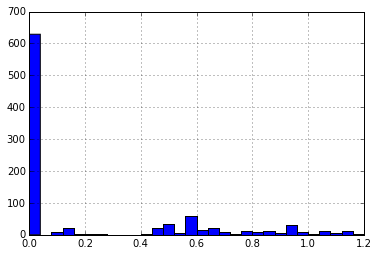

In [93]:
unit_id_var = dict()

for line in good_countries_only.groupby('_unit_id'):
    unit_id_var[line[0]] = line[1]['please_make_your_relevancy_judgment'].var()
    
pd.Series(data=unit_id_var).hist(bins=30)

high_agreement = []
for line in good_countries_only.iterrows():
    high_agreement.append(unit_id_var[line[1]['_unit_id']]<.1)

0.22070802005
0.194335390799
0.247080649301


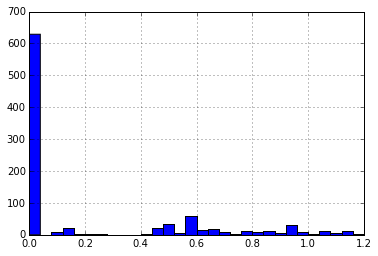

In [94]:
## ### compare with the variance from before and see if the judgments are better this way

def pair_variance(dataframe):
    pair_variance_list = dict()
    for line in dataframe.groupby('_unit_id'):
        pair_variance_list[line[0]] = line[1]['please_make_your_relevancy_judgment'].var()
    return pair_variance_list

old_variances = pd.Series(data=pair_variance(raw_df).values())
old_variances.hist(bins= 30)
print pd.Series(data=pair_variance(raw_df).values()).mean()

n = len(old_variances)
z = 1.96
mu = old_variances.mean()
stuff = mu * (1-mu)
stuff = stuff / n
stuff =  stuff**.5
ci_low = mu - z*stuff
ci_high = mu + z*stuff
print ci_low
print ci_high

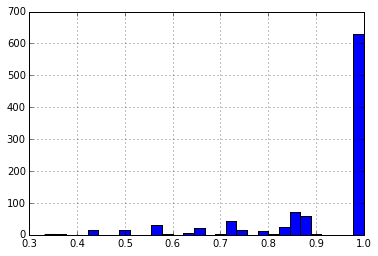

In [95]:
## detect majority judgments (and how much of a majority)

raw_df = good_countries_only

modes = []
mode_counts = []
judgment_counts = []
plurality_percentages = []
plurality_judgment = dict()

for line in raw_df.groupby('_unit_id'):
    unit_id = line[0]
    judgments = line[1]['please_make_your_relevancy_judgment']
    mode = judgments.mode()
    mode = int(mode[0])
    modes.append(mode)
    mode_count = 0
    for judgment in judgments:
        if judgment == mode:
            mode_count += 1
    mode_counts.append(mode_count)
    judgment_count = len(judgments)
    judgment_counts.append(judgment_count)
    plurality_percentage = (mode_count +0.0)/judgment_count
    plurality_percentages.append(plurality_percentage)
    plurality_judgment[line[0]] = mode, plurality_percentage
    

pd.Series(data= plurality_percentages).hist(bins=30)

887
6638
(6638, 28)
(6638, 28)


/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


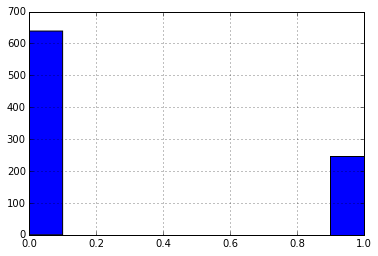

In [127]:
# eliminate lack of agreement 
# identify agreement with winner-take-all approach
keepers = []
winners = dict()
cutoff_threshold = .6

for plur_percent in plurality_judgment:
    unit_id = plur_percent
    values = plurality_judgment[plur_percent]
    vote = values[0]
    percent = values[1]
    if percent >= .6:
        keepers.append(1)
        if vote == 1:
            winners[unit_id] = 0 
        else:
            winners[unit_id] = 1
    else:
        keepers.append(0)


# basic review of the previous; keeping a great deal of the pairs and coming with a decent distribution of rel/irrel
pd.Series(data=winners.values()).hist()
print len(winners)

# reduce to only those who have the majority (the winner-take-all approach) and then push it to the database 
# this is inefficient, but i'm in a rush (ironic, eh?)
winner_set = set(winners.keys())
winner_list = []
for line in good_countries_only.iterrows():
    if line[1]._unit_id in winner_set:
        winner_list.append(1)
    else:
        winner_list.append(0)
        

#double check the lengths
print len(winner_list)
print good_countries_only.shape
    
# add it in and then filter against the concensus
good_countries_only['majority'] = winner_list
good_countries_only = good_countries_only[good_countries_only.majority == 1]
print good_countries_only.shape



In [128]:
## normalize
##

def normalize(list_of_numbers):
    min_value = min(list_of_numbers)
    list_less_min = list_of_numbers - min_value
    max_value = max(list_less_min)
    normalized_values = list_less_min / max_value
    return normalized_values

353
534


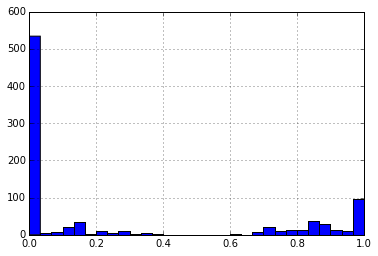

In [129]:
# get the unit ides for the key for the data frame
unit_ids = []
mean_scores_list = []
mode_scores_list = []
job_count_list = []

for group in good_countries_only.groupby('_unit_id')['please_make_your_relevancy_judgment']:
    unit_ids.append(group[0])
    mean_scores_list.append(np.mean(group[1]))
    job_count_list.append(len(group[1]))
    

unit_id_scores = pd.DataFrame()
unit_id_scores['_unit_id'] = unit_ids
unit_id_scores['mean_score'] = mean_scores_list
unit_id_scores['normalized_mean_score'] = normalize(mean_scores_list)
unit_id_scores['job_count'] = job_count_list

unit_id_scores['normalized_mean_score'].hist(bins = 30, )  #[unit_id_scores['normalized_mean_score'] != 0]

print unit_id_scores['normalized_mean_score'][unit_id_scores['normalized_mean_score'] != 0].count()
print unit_id_scores['normalized_mean_score'][unit_id_scores['normalized_mean_score'] == 0].count()


cutoff_value = unit_id_scores.median()['normalized_mean_score']

unit_id_scores['rounded_normalized_mean_scores'] =  unit_id_scores['normalized_mean_score'].apply(lambda x: x > int(cutoff_value))
unit_id_scores['majority_vote'] = winners.values()

In [130]:
# trust weighted average !!!!
trust_weighted_mean = dict()

for line in good_countries_only.groupby('_unit_id'):
    total_trust = line[1]['_trust'].sum()
    ind_trust_vector = line[1]['_trust']
    ind_judgment_vector = line[1]['please_make_your_relevancy_judgment']
    trust_mean = (ind_trust_vector * ind_judgment_vector).mean()
    trust_weighted_mean[line[0]] = trust_mean

normalized_trust_weighted_mean = normalize(trust_weighted_mean.values())
unit_id_scores['normalized_trust_weighted_mean'] = normalized_trust_weighted_mean
unit_id_scores['trust_weighted_mean'] = trust_weighted_mean

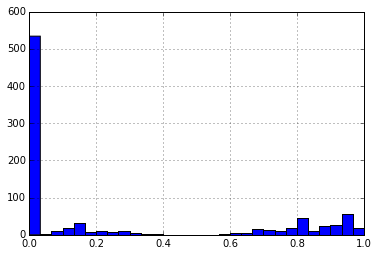

In [131]:
pd.Series(data=normalized_trust_weighted_mean).hist(bins=30)

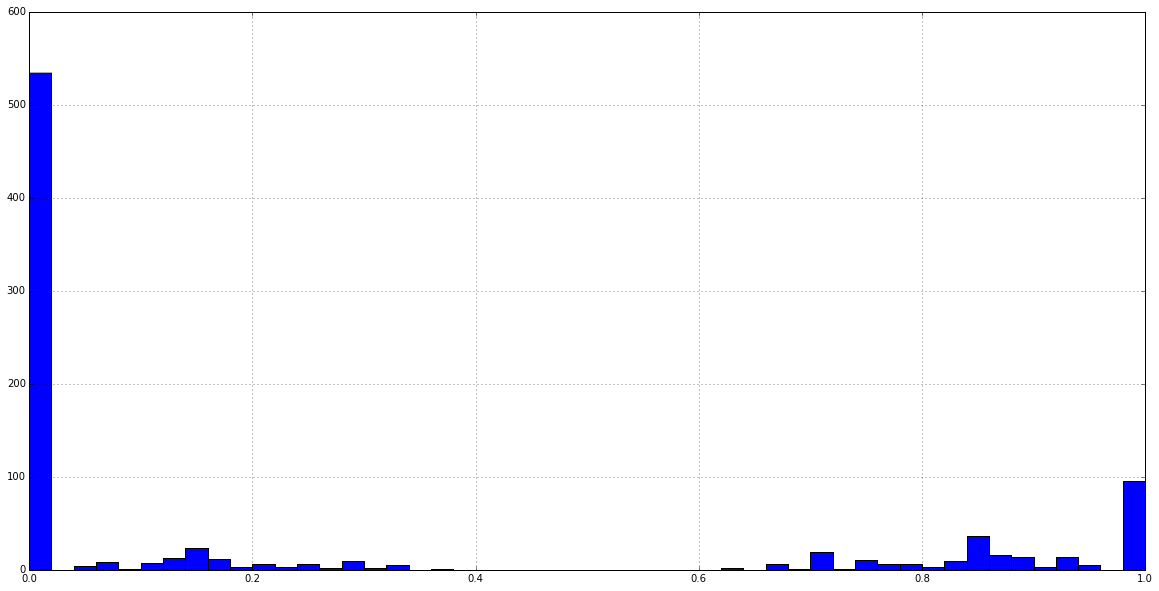

In [132]:
unit_id_scores['normalized_mean_score'].hist(bins = 50, figsize= (20,10))
#unit_id_scores['mean_score'].hist(bins = 50)

In [133]:
unit_id_scores

,_unit_id,mean_score,normalized_mean_score,job_count,rounded_normalized_mean_scores,majority_vote,normalized_trust_weighted_mean,trust_weighted_mean
0,866237181,1.000000,0.000000,7,False,0,0.008156,866237181
1,866237182,1.000000,0.000000,8,False,0,0.011450,866237182
2,866237183,1.000000,0.000000,6,False,0,0.011955,866237183
3,866237184,1.000000,0.000000,8,False,0,0.006191,866237184
4,866237185,1.000000,0.000000,7,False,0,0.002936,866237185
5,866237186,1.000000,0.000000,7,False,0,0.008384,866237186
6,866237187,1.000000,0.000000,7,False,0,0.009060,866237187
7,866237188,1.000000,0.000000,6,False,0,0.002775,866237188
8,866237189,1.000000,0.000000,7,False,0,0.010912,866237189
9,866237190,1.000000,0.000000,6,False,0,0.008009,866237190


(887, 9)
(887, 9)



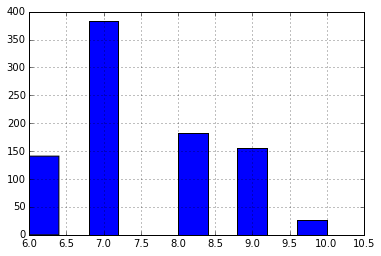

In [134]:
## what about the unit pairs for which ther are relatively few votes? 
###
##

# see the hist is the same
unit_id_scores['job_count'].apply(lambda x: x if (x>5) else False).hist()

# remove the underscored elements 
unit_id_scores['min_job_req'] = unit_id_scores['job_count'].apply(lambda x: 1 if (x>4) else 0)
new_df = unit_id_scores[unit_id_scores['min_job_req'] == True]
print new_df.shape
print unit_id_scores.shape
print 

In [135]:
# apply to the full score dataset

id_set = set(list(new_df['_unit_id']))
#print len(id_set)

underscore_list = []
for row in good_countries_only.iterrows():
    
    if row[1]['_unit_id'] in id_set:
        underscore_list.append(1)
    else:
        underscore_list.append(0)
        
print len(underscore_list)
print sum(underscore_list)
print len(underscore_list) - sum(underscore_list)
print 
print 'that loses another' 
print ((len(underscore_list) - sum(underscore_list) + 0.0)/len(underscore_list))*100

6638
6638
0

that loses another
0.0


In [136]:
original_length = len(pd.read_csv('cleaned_urx_data.csv'))
print original_length
final_length = len(underscore_list)
print final_length

print "the total loss by eliminating robots, fraud countries, and underscored pairs is: " + str(original_length - final_length)
print str(round(100*(1 - float(final_length)/original_length),2)) + "%"

9058
6638
the total loss by eliminating robots, fraud countries, and underscored pairs is: 2420
26.72%


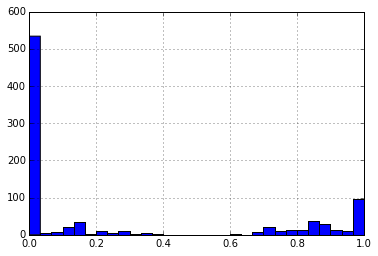

In [137]:
new_df['normalized_mean_score'].hist(bins = 30)

In [138]:
new_df.head()

,_unit_id,mean_score,normalized_mean_score,job_count,rounded_normalized_mean_scores,majority_vote,normalized_trust_weighted_mean,trust_weighted_mean,min_job_req
0,866237181,1,0,7,False,0,0.008156,866237181,1
1,866237182,1,0,8,False,0,0.011450,866237182,1
2,866237183,1,0,6,False,0,0.011955,866237183,1
3,866237184,1,0,8,False,0,0.006191,866237184,1
4,866237185,1,0,7,False,0,0.002936,866237185,1


In [142]:
# output to unit pair scores table
#
#
#
#
#
#
#
#
# put this into the database, so that i don't need to process it each time, 
#becuase it is very slow
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [143]:
# adjust to make sure you have the right experiment for the database 

new_df.to_sql('scores_exp2', engine, if_exists = 'replace')

#unit_id_scores.to_sql('scores', engine, if_exists = 'replace')